### Поиск главных хитмейкеров 2024 года

**Описание**:

Для начала перенесём позиции чарт Billboard Global 200 (его версии на сервисе webarchive) за 2024 год в удобный для нас формат. Затем для каждой песни выясним жанр, авторов и продюссеров, используя для этого сервис Shazam

In [2]:
from bs4 import BeautifulSoup
from lxml import html
import requests
from selenium import webdriver as wd
from selenium.webdriver.common.keys import Keys
import time
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
import csv
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных

In [9]:
header={"accept-encoding": "gzip, deflate"}
req=requests.get('https://web.archive.org/web/20241213143621/https://www.billboard.com/charts/year-end/2024/billboard-global-200/')
scr=(req.text)
chart=[]
soup=BeautifulSoup(scr,'lxml')
items = soup.find_all('li', {'class': 'o-chart-results-list__item // lrv-u-flex-grow-1 lrv-u-flex lrv-u-flex-direction-column lrv-u-justify-content-center lrv-u-border-b-1 lrv-u-border-color-grey-light lrv-u-padding-l-2 lrv-u-padding-l-1@mobile-max'})
for item in items:
    song = item.find('h3', {'class': 'c-title a-font-primary-bold-s u-letter-spacing-0021 lrv-u-font-size-18@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max'})
    artist = item.find('span', {'class': 'c-label a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block'})
    if artist or song:
        chart.append({'pos':len(chart)+2,'artist': artist.text.strip(),
                  'song': song.text.strip()})
chart.insert(0, {'pos': 1,'artist': 'Benson Boone', 'song': 'Beautiful Things'})
for entry in chart:
    entry['artist']=entry['artist'].replace(' &', ',')
    entry['artist']=entry['artist'].replace(' X', ',')
    entry['artist']=entry['artist'].replace(' x', ',')
    entry['artist']=entry['artist'].replace(' Featuring', ',')
    entry['artist']=entry['artist'].replace(' vs.', ',')

In [ ]:
for entry in chart:
    browser = wd.Chrome()
    browser.get('https://www.shazam.com/')
    open_search = browser.find_element("class name", 'Search_icon__Poc_G')
    open_search.click()
    search = browser.find_element("class name", "Search_input__HkJTl")
    search.send_keys(f'{entry["artist"]} {entry["song"]}')
    time.sleep(1)
    search.click()
    search.send_keys(Keys.ENTER)
    time.sleep(2)
    soup_1 = BeautifulSoup(browser.page_source, 'lxml')
    items=[]
    people = soup_1.find_all('div', {'class': 'SongCredits_people__pHGX5'})
    categories = soup_1.find_all('span', {'class': 'Text-module_text-gray-900__Qcj0F Text-module_fontFamily__cQFwR Text-post-module_size-base__o144k Text-module_fontWeightBold__4NHce'})
    if len(people) == len(categories):
        for i in range(len(people)):
            people[i]=people[i].find_all('div', {'class': 'Text-module_text-black-200__8cY0O Text-module_fontFamily__cQFwR SongCredits_name__3ItNW Text-post-module_size-base__o144k Text-module_fontWeightNormal__kB6Wg Text-module_textOverflowEllipsis__J7BCo'})
            for j in range(len(people[i])):
                people[i][j]=people[i][j].text.strip()
            items.append([categories[i], people[i]])
    time.sleep(1)
    if soup_1.find('h3', {'class': 'Text-module_text-white__l-SDK Text-module_fontFamily__cQFwR TrackPageHeader_genreNoUrl__u_v2b Text-post-module_size-base__o144k Text-module_fontWeightNormal__kB6Wg Text-module_headingReset__Mn-tB'}):
        artist=soup_1.find('span', {'class': 'Text-module_text-white__l-SDK Text-module_fontFamily__cQFwR TrackPageHeader_link__q0Id5 Text-post-module_size-md-large__4coGy Text-module_fontWeight500__iJDFU'}).text.strip()
        genre=soup_1.find('h3', {'class': 'Text-module_text-white__l-SDK Text-module_fontFamily__cQFwR TrackPageHeader_genreNoUrl__u_v2b Text-post-module_size-base__o144k Text-module_fontWeightNormal__kB6Wg Text-module_headingReset__Mn-tB'}).text.strip()
    artists=[]
    songwriters=[]
    producers=[]
    credit={'song':entry['song'],'artist': artist,'genre': genre}
    for item in items:
        credit[item[0].text.strip()]=item[1]
    credits.append(credit)
    browser.quit()
adf=pd.DataFrame(credits) #adf - active data frame
pd.DataFrame(credits).to_csv('DATA_raw.csv')

Эта часть сбора данных занимает примерно 40 минут, поэтому работа над проектом велась с предсохраненными файлами, из-за чего типы некоторых объектов менялись, но приводились к нужному виду при использовании в функциях.

## Очистка данных и подготовка к анализу

In [ ]:
print(adf.head(10))

In [ ]:
adf.columns
adf.isna().sum()
adf.head()
print(adf.dtypes)

Мы видим, что почти у половины песен на сайте Shazam не были указаны продюссеры, поэтому в рамках этого мини-исследования этот параметр придётся опустить. Можно заметить, что часть песен не была найдена в Shazam в принципе. Для этих песен найдём авторов в Apple Music. Исполнителей повторно искать не нужно, потому что они уже есть в списке chart. Списки исполнителей и авторов будут позднее приведены к спискам строк. Распределение данных будет рассмотренно дальше.

In [ ]:
adf.columns=['song', 'artist', 'genre', 'artists(shazam)', 'songwriters',
       'producers']
adf.index += 1

In [ ]:
empty_list=[]
for i in range(200):
    artists=chart[i]['artist'].split(', ')
    if not credits[i]['artists(shazam)']:
        empty_list.append(i)
        print(artists, credits[i]['song'], i)

In [ ]:
def missing_songwriters(list_):
    songwriters_local=[]
    driver = wd.Chrome()
    driver.get(list_[1])
    soup = BeautifulSoup(driver.page_source,'html.parser')
    items=soup.find_all('div', {'class':'artist-metadata svelte-16yxrct'})
    driver.close()
    for item in items:
        if item.find('div', {'class':'artist-roles svelte-16yxrct'}).text.strip()=='Songwriter' or item.find('div', {'class':'artist-roles svelte-16yxrct'}).text.strip()=='Lyrics' or 'Lyrics' in item.find('div', {'class':'artist-roles svelte-16yxrct'}).text.strip():
            songwriters_local.append(item.find('div', {'class':'artist-name svelte-16yxrct'}).text.strip())
    if str(adf.at[list_[0], 'songwriters'])=='nan':
        adf.at[list_[0], 'songwriters'] = str(songwriters_local)
        print(str(songwriters_local), adf.at[list_[0], 'songwriters'])
missing_lists=[[22, 'https://music.apple.com/us/song/save-your-tears-remix/1563812775'], [27, 'https://music.apple.com/us/song/end-of-beginning/1632448108'], [31, 'https://music.apple.com/us/song/luna/1719170507'], [44, 'https://music.apple.com/us/song/like-that/1737150439'], [51, 'https://music.apple.com/us/song/perro-negro/1710983279'], [66, 'https://music.apple.com/us/song/bling-bang-bang-born/1720332181'], [67, 'https://music.apple.com/us/song/yellow/1122782283'], [91, 'https://music.apple.com/us/song/thinkin-bout-me/1667991031'], [101, 'https://music.apple.com/us/song/redrum/1725240530'], [117, 'https://music.apple.com/us/song/type-shit/1737320968'], [118, 'https://music.apple.com/us/song/monaco/1710982872'], [125, 'https://music.apple.com/us/song/popular-feat-playboi-carti-music-from-the-hbo/1691920672'], [126, 'https://music.apple.com/us/song/i-dont-wanna-wait/1737218564'], [143, 'https://music.apple.com/us/song/bellakeo/1717837513'], [159, 'https://music.apple.com/us/song/la-bebe-remix/1674086215'], [169, 'https://music.apple.com/us/song/lady-gaga/1694412892'], [177, 'https://music.apple.com/us/song/i-know/1708274785'], [181, 'https://music.apple.com/us/song/whatever/1725170949'], [189, 'https://music.apple.com/us/song/dial-drunk/1696596473']]
for list_ in missing_lists:
    missing_songwriters(list_)

Некоторые авторы указаны под разными именами. Воспользовавшись консультацией у DeepSeek, были найдены такие случаи. Нужно привести все имена к одному виду.

In [22]:
name_mapping = {
    "ALEXIS ARMANDO FIERRO": "The Weeknd",
    "Abel Makkonen Tesfaye": "The Weeknd",
    "Abel Tesfaye": "The Weeknd",
    "Alexis Armando Fierro Roman": "The Weeknd",
    "Billie Eilish OConnell": "Billie Eilish",
    "Aubrey Drake Graham": "Drake",
    "Austin Post": "Post Malone",
    "Finneas Baird OConnell": "Finneas",
    "Finneas O’Connell": "Finneas",
    "FINNEAS": "Finneas",
    "Finneas O\x92Connell": "Finneas",
    "Jacques Bermon Webster II": "Travis Scott",
    "Marshall Mathers": "Eminem",
    "Nayvadius Wilburn": "Future",
    "Solana Rowe": "SZA",
    "Amala Zandile Dlamini": "Doja Cat",
    "Jahseh Onfroy": "XXXTentacion",
    "Jordan Carter": "Playboi Carti",
    "Khalid Robinson": "Khalid",
    "Shéyaa Bin Abraham-Joseph": "21 Savage",
    "Ben Haggerty": "Macklemore",
    "Christopher Breaux": "Frank Ocean",
    "Bleta Rexha": "Bebe Rexha",
    }

def normalize_name(name):
    if name in name_mapping.keys():
        return name_mapping[name]
    else:
        return 0
for j in range(1,len(adf)):
    adf.at[j, 'songwriters'] = str(adf['songwriters'][j])[1:-2].replace("'",'').replace('\\', '').replace('"', '').split(', ')
    norm_songwriters=[]
    for i in range(len(adf['songwriters'][j])):
        if normalize_name(adf['songwriters'][j][i])!=0:
            norm_songwriters.append(normalize_name(adf['songwriters'][j][i]))
        else:
            norm_songwriters.append(adf['songwriters'][j][i])
        
    adf.at[j, 'songwriters',]=list(set(norm_songwriters))

In [ ]:
adf.columns
adf = adf.drop('Unnamed: 0', axis=1)
adf = adf.drop('Unnamed: 0.1', axis=1)

In [ ]:
pd.DataFrame(adf).to_csv('DATA_Final.csv')

## Анализ и визуализация

In [24]:
adf=pd.read_csv('DATA_final.csv', encoding='latin-1')
for j in range(1,len(adf)):
    adf.at[j, 'songwriters'] = str(adf['songwriters'][j])[1:-2].replace("'",'').replace('\\', '').replace('"', '').split(', ')
    norm_songwriters=[]
    for i in range(len(adf['songwriters'][j])):
        if normalize_name(adf['songwriters'][j][i])!=0:
            norm_songwriters.append(normalize_name(adf['songwriters'][j][i]))
        else:
            norm_songwriters.append(adf['songwriters'][j][i])
        
    adf.at[j, 'songwriters',]=list(set(norm_songwriters))

In [ ]:
Зададим функции, которые будут создавать списки авторов с самым большим количеством песен в чарте и исполнителей с учётом позиций их песен в чарте  

In [11]:
def create_songwriter_list(dataframe):
    songwriters_lists=[]
    for i in dataframe['songwriters']:
        songwriters_lists.append(i)
    songwriters_ranked=[]
    songwriters_clone=[]
    for i in songwriters_lists:
        if len(str(i))>4:
            for j in range(len(i)):
                if i[j] not in songwriters_clone:
                    count=0
                    for k in songwriters_lists:
                        if k!=[]:
                            if i[j] in k:
                                count+=1
                    songwriters_clone.append(i[j])
                    songwriters_ranked.append([count, i[j]])
    return sorted(songwriters_ranked)
            

In [12]:
def create_artists_list(chart_):
    artists_lists=[]
    for i in chart_:
        j=str(i['artist'])
        artists_lists.append(j.split(', '))
    artists_clone=[]
    artists_ranked=[]
    for i in range(len(chart_)):
        for artist_list in artists_lists:
            for artist in artist_list:
                if artist not in artists_clone:
                    count=0
                    songs=[]
                    for j in range(len(chart_)):
                        if chart_[j]['artist'].find(artist)>=0:
                            count+=1
                            songs.append([chart_[j]['song'], chart_[j]['pos']])
                    artists_ranked.append([count, artist, songs])
                    artists_clone.append(artist)
    return sorted(artists_ranked)
    

In [ ]:
Зададим функцию для вывода гистограмм.

In [13]:
def songwriters_chart(data):
    if not data:
        print("Ошибка: входные данные пусты.")
        return
    
    # Разделяем данные на количества и имена
    counts = [item[0] for item in data]
    artists = [item[1] for item in data]
    
    # Создаем фигуру и оси
    plt.figure(figsize=(12, 6))
    
    # Строим гистограмму
    bars = plt.bar(artists, counts, color='skyblue')
    
    # Настройки внешнего вида
    plt.xlabel('Авторы')
    plt.ylabel('Количество песен в чарте')
    plt.title('Количество песен авторов в чарте')
    plt.xticks(rotation=45, ha='right')  # Поворот подписей для читаемости
    
    # Добавляем подписи значений над столбцами
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{int(height)}',
                 ha='center', va='bottom')
    
    # Оптимизируем расположение элементов
    plt.tight_layout()
    
    # Показываем график
    plt.show()
def chart_perfomance_visual(data):
    # Извлекаем данные
    num_songs = data[0]
    artist = data[1]
    songs = data[2]
    
    # Названия песен и позиции в чарте
    song_titles = [song[0] for song in songs]
    chart_positions = [song[1] for song in songs]
    
    # Создаем гистограмму
    plt.figure(figsize=(12, 6))
    plt.bar(song_titles, chart_positions, color='skyblue')
    plt.xlabel('Песни')
    plt.ylabel('Позиция в чарте (меньше — лучше)')
    plt.title(f'Чарт-позиции песен {artist}')
    plt.xticks(rotation=45, ha='right')
    xa=plt.gca()
    plt.axis([None, None, 0, 200])
    xa.invert_yaxis()  # Чтобы топ-1 был вверху
    plt.tight_layout()
    plt.show()

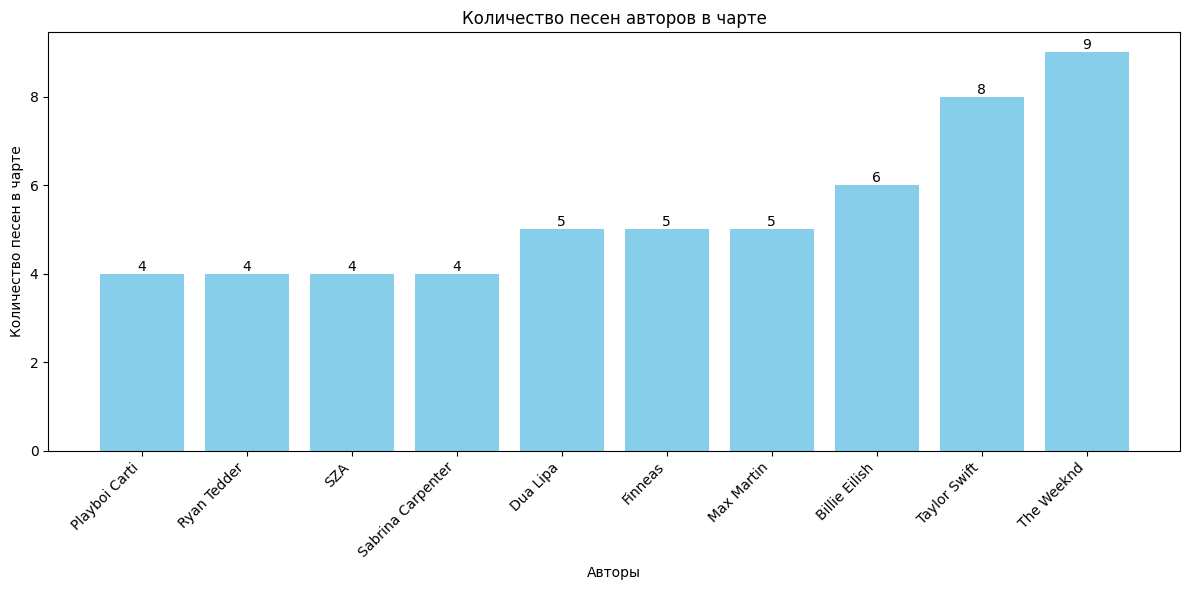

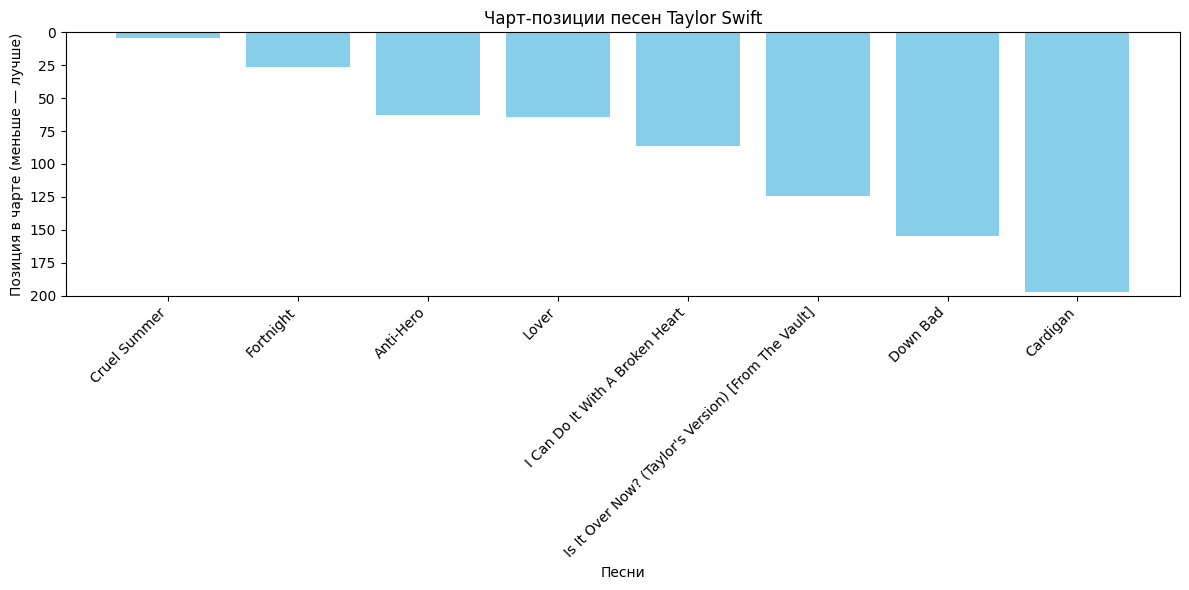

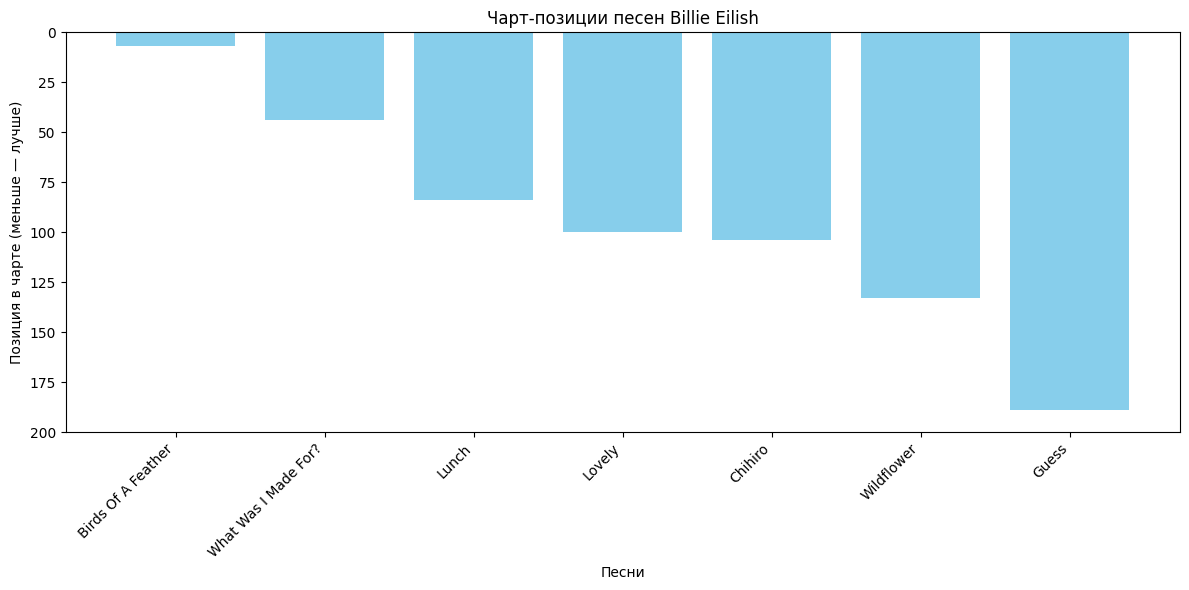

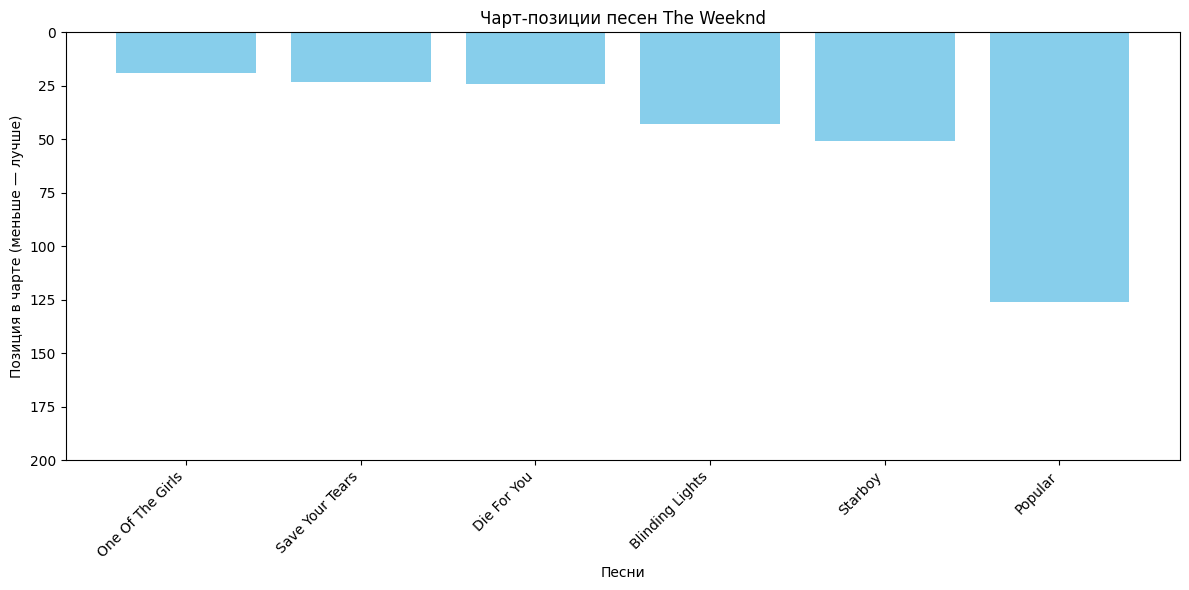

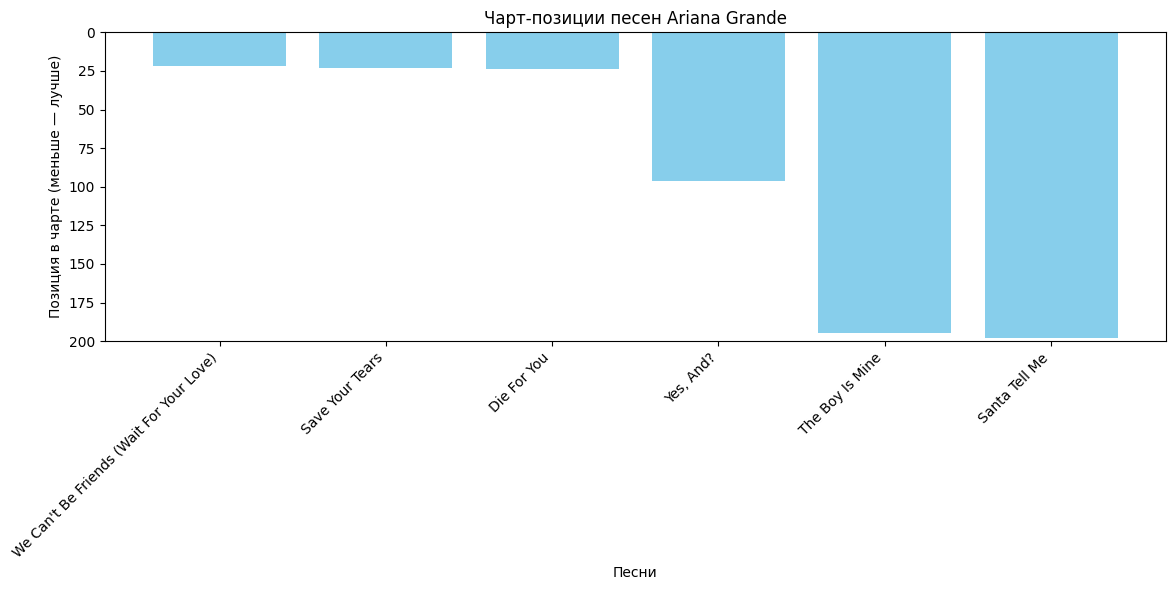

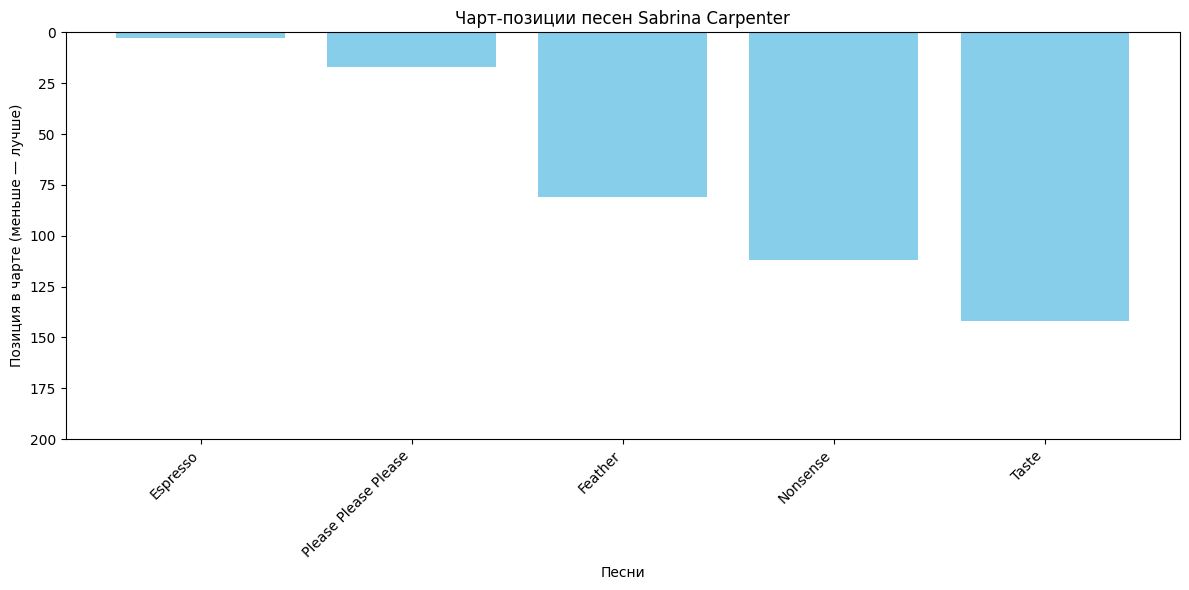

In [23]:
artists_ranked=create_artists_list(chart)
songwriters_chart(create_songwriter_list(adf)[-10:])
chart_perfomance_visual(artists_ranked[-1])
chart_perfomance_visual(artists_ranked[-2])
chart_perfomance_visual(artists_ranked[-3])
chart_perfomance_visual(artists_ranked[-4])
chart_perfomance_visual(artists_ranked[-5])

Первый график выводит количество песен у авторов, чьих песен в чарте больше всего.
Второй и последующие графики демонстрируют позиции песен в чарте у артистов, у которых в чарт попало наибольшее количество песен. В угоду логичности визуализации пришлось немного пожертвовать интуитивностью. Столбцы показывают позицию песни в чарте: чем меньше столбец - тем выше песня в чарте. Так можно оценить не только количество, но и примерный общий успех артиста за год.

In [16]:
adf['genre'].value_counts()

genre
Pop                  56
Hip-Hop/Rap          28
Alternative          17
Country              12
Dance                12
Latino               10
Regional Mexican     10
K-Pop                 8
R&B/Soul              7
Rock                  7
Singer/Songwriter     6
Christmas             5
Hard Rock             5
Latin Urban           5
Soundtrack            3
Rap                   2
Trance                1
Neo-Soul              1
Karaoke               1
Old School Rap        1
Children's Music      1
Anime                 1
Reggae                1
Name: count, dtype: int64

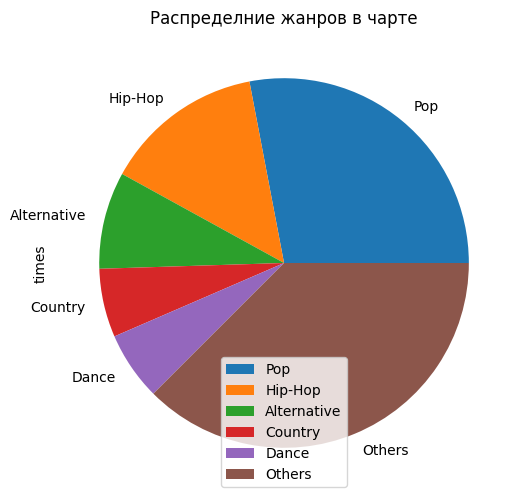

In [17]:
data = {'genres':['Pop', 'Hip-Hop', 'Alternative','Country', 'Dance', 'Others'],
       'times':[56,28,17,12,12,75]}
df = pd.DataFrame(data)
df.set_index('genres', inplace=True)
df.plot(kind='pie', figsize=(6,6), y='times')
plt.title('Распределние жанров в чарте')
plt.show()

Здесь мы видим соотношение 5 самых популярных жанров и остальных жанров, объединённых в одну категорию.
Рассмотрим 3 самых популярных жанра: построим графики аналогичные тем, что мы сделали для всего чарт

In [26]:
df_pop=adf[adf['genre']=='Pop']
chart_pop=[]
for entry in chart:
    if entry['song'] in df_pop['song'].values:
        chart_pop.append(entry)

In [32]:
df_pop.head()

,Unnamed: 0,song,artist,genre,artists(shazam),songwriters,producers
0,1,Beautiful Things,Benson Boone,Pop,['Benson Boone'],"['Evan Blair', 'Benson Boone', 'Jackson Lafran...","['Evan Blair', 'Randy Merrill', 'Alex Ghenea']"
1,2,Lose Control,Teddy Swims,Pop,['Teddy Swims'],"[Mikky Ekko, Joshua Coleman, Marco INFAMOUS Ro...",NaN
2,3,Espresso,Sabrina Carpenter,Pop,['Sabrina Carpenter'],"[Sabrina Carpenter, Steph Jones, Amy Allen, Ju...",NaN
3,4,Cruel Summer,Taylor Swift,Pop,"['Taylor Swift', 'Jack Antonoff', 'Annie Clark...","[Jack Antonoff, Annie Clark, Taylor Swift]","['Taylor Swift', 'Jack Antonoff', 'Laura Sisk'..."
4,5,Greedy,Tate McRae,Pop,['Tate McRae'],"[Jasper Harris, Amy Allen, Ryan Tedder, Tate M...","['Ryan Tedder', 'Jasper Harris', 'Manny Marroq..."


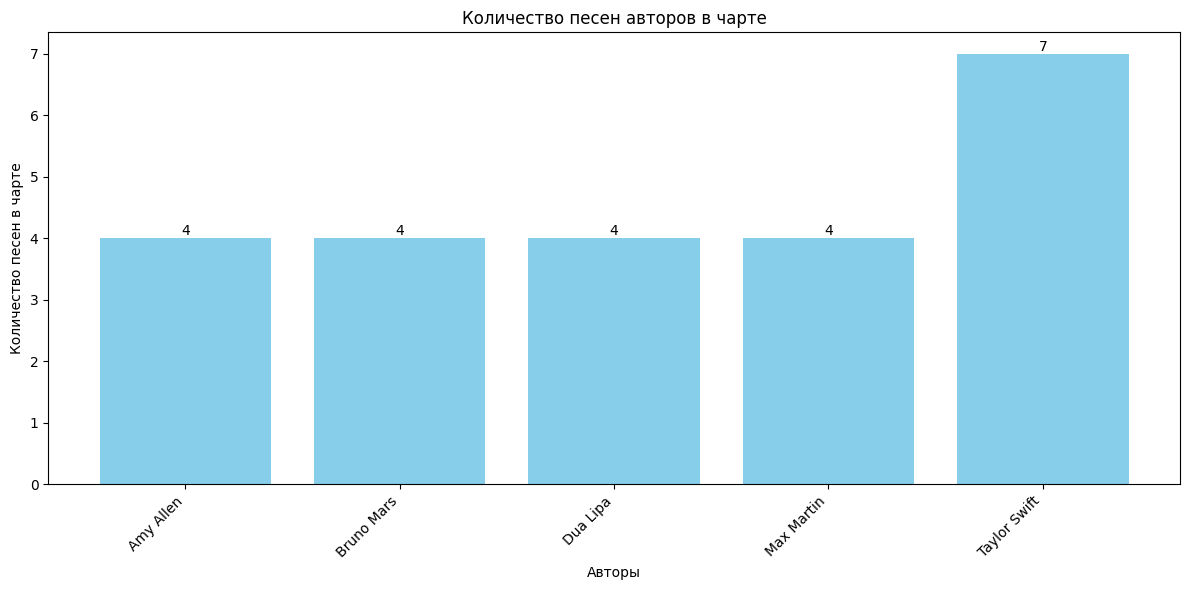

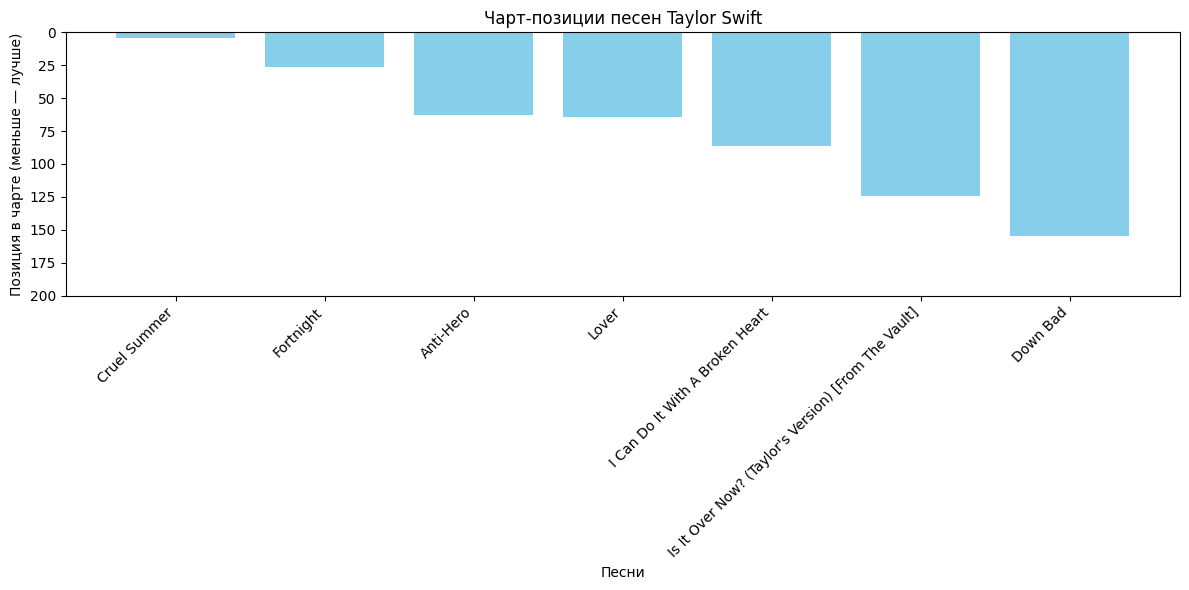

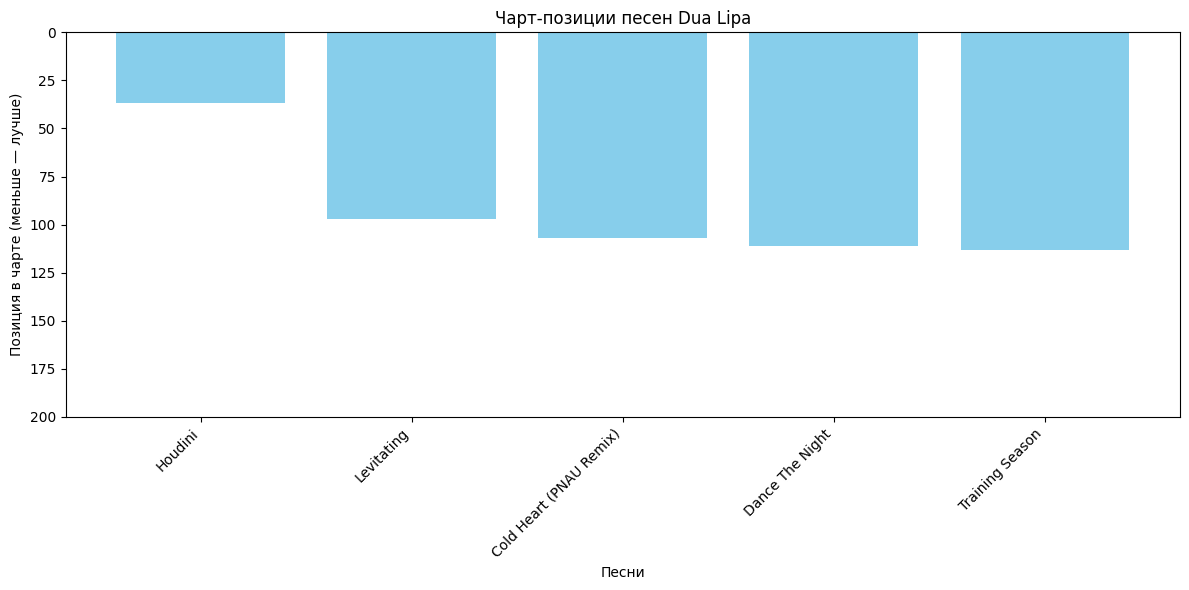

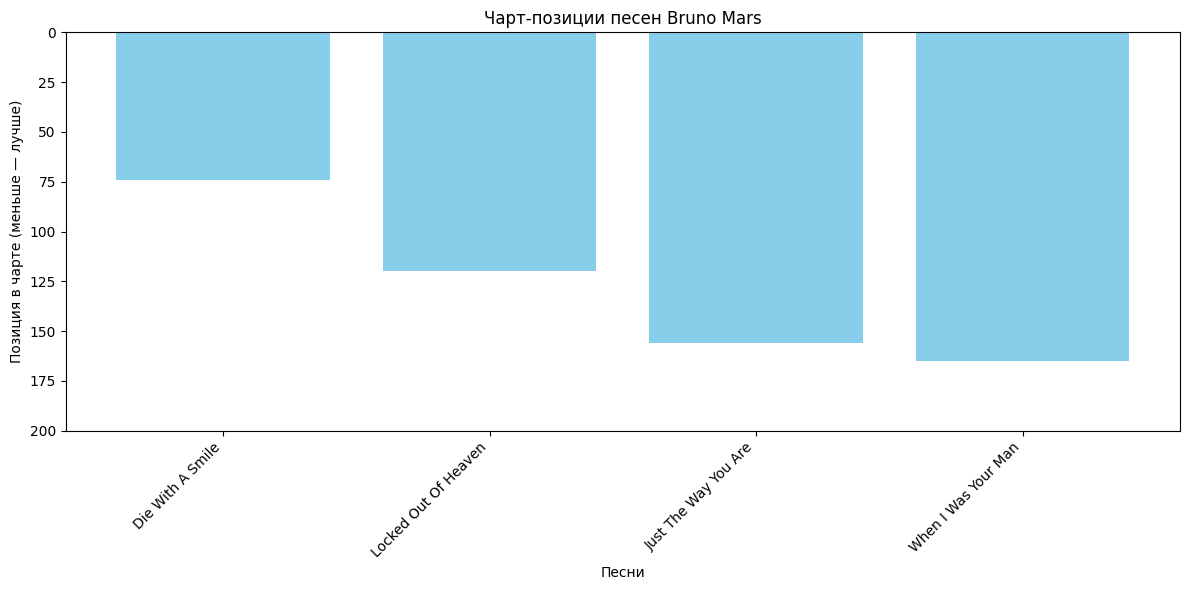

In [27]:
pop_artists_ranked=create_artists_list(chart_pop)
songwriters_chart(create_songwriter_list(df_pop)[-5:])
chart_perfomance_visual(pop_artists_ranked[-1])
chart_perfomance_visual(pop_artists_ranked[-2])
chart_perfomance_visual(pop_artists_ranked[-3])

In [28]:
df_hiphop=adf[adf['genre']=='Hip-Hop/Rap']
chart_hiphop=[]
for entry in chart:
    if entry['song'] in df_hiphop['song'].values:
        chart_hiphop.append(entry)

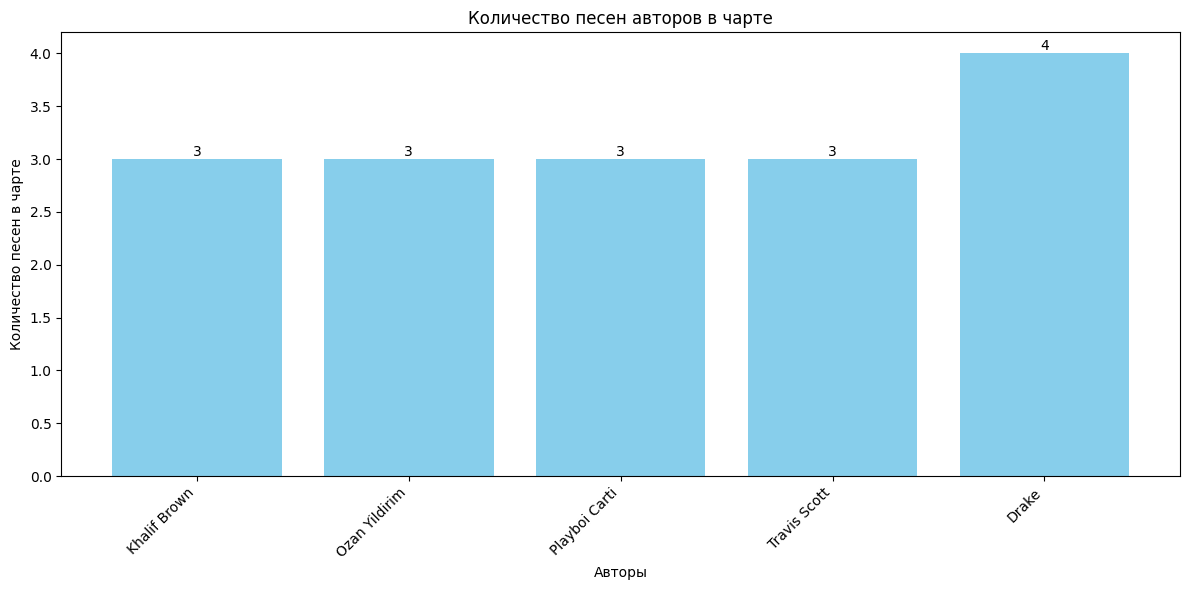

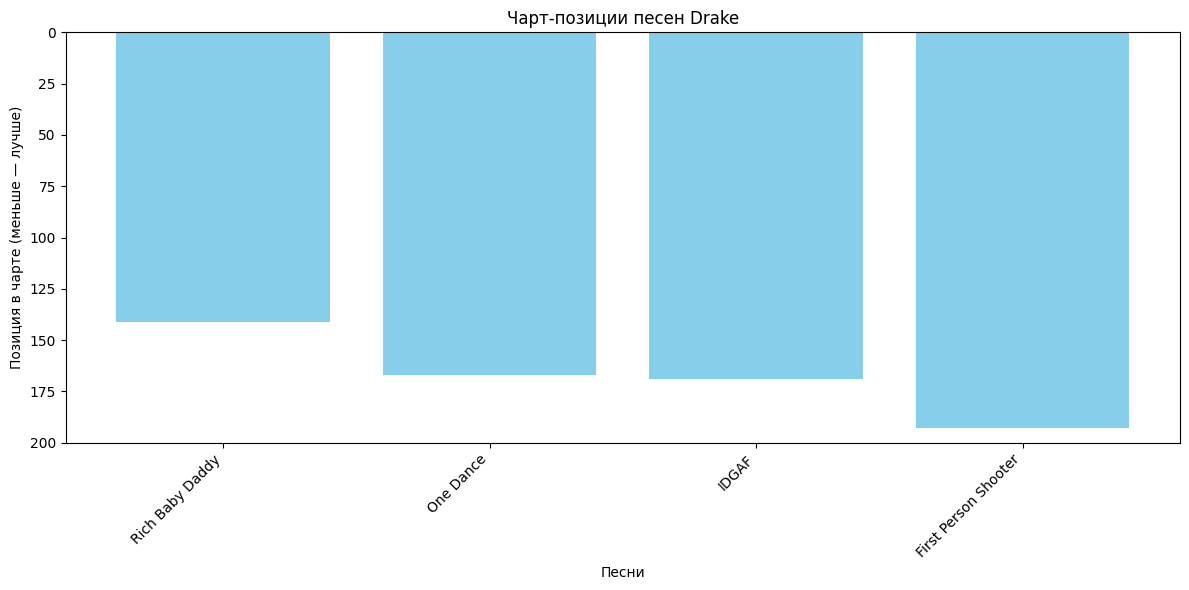

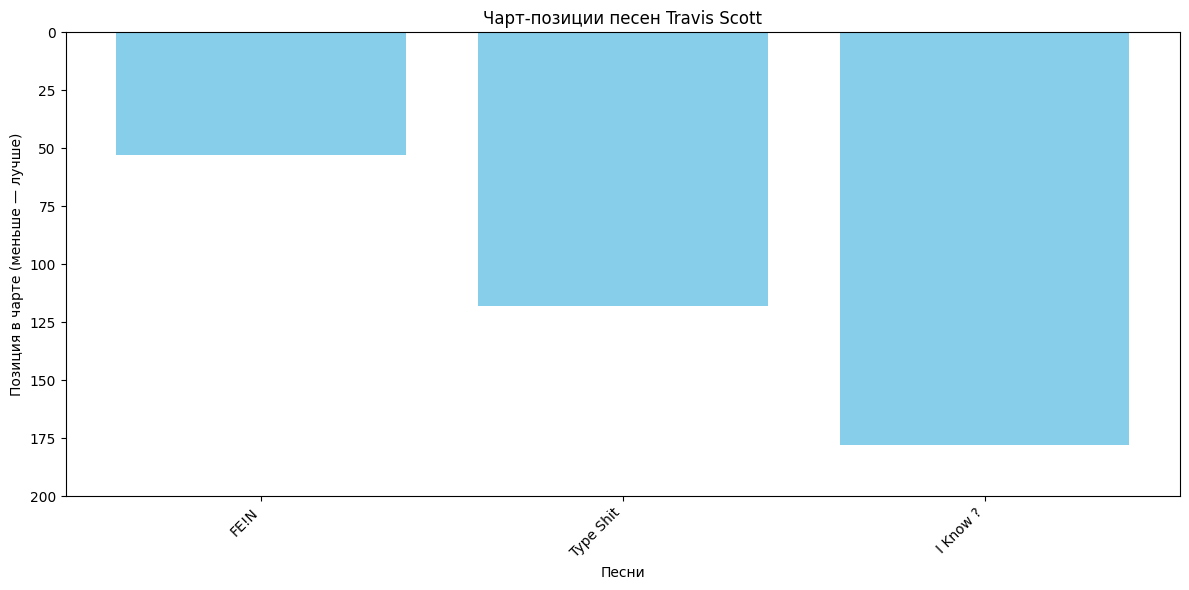

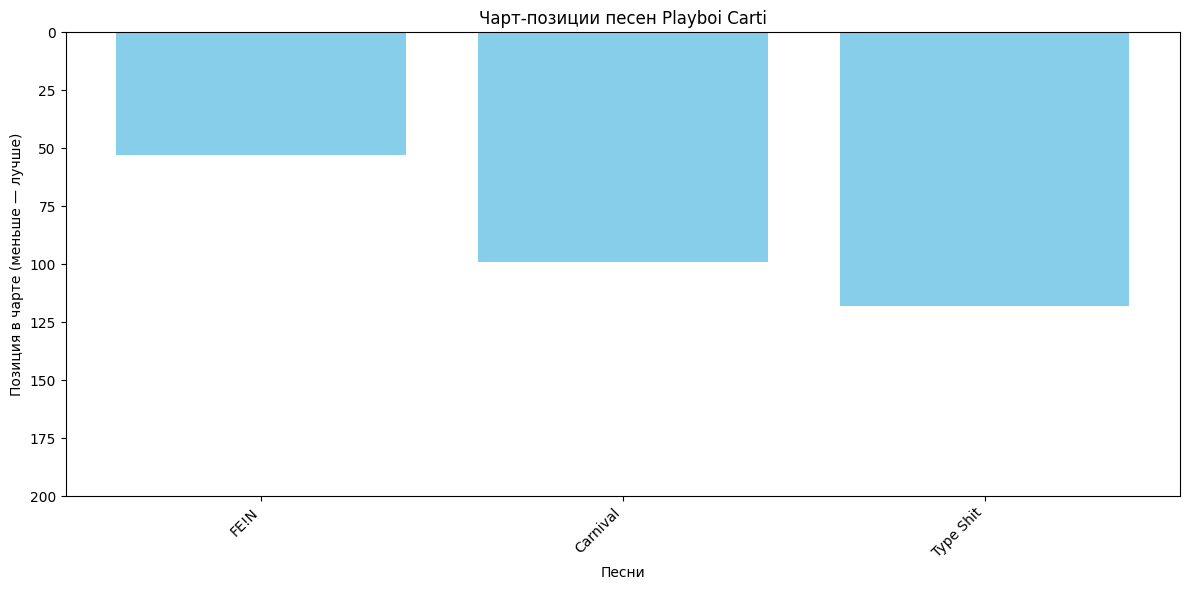

In [29]:
artists_ranked=create_artists_list(chart_hiphop)
songwriters_chart(create_songwriter_list(df_hiphop)[-5:])
chart_perfomance_visual(artists_ranked[-1])
chart_perfomance_visual(artists_ranked[-2])
chart_perfomance_visual(artists_ranked[-3])

In [30]:
df_alt=adf[adf['genre']=='Alternative']
chart_alt=[]
for entry in chart:
    if entry['song'] in df_alt['song'].values:
        chart_alt.append(entry)

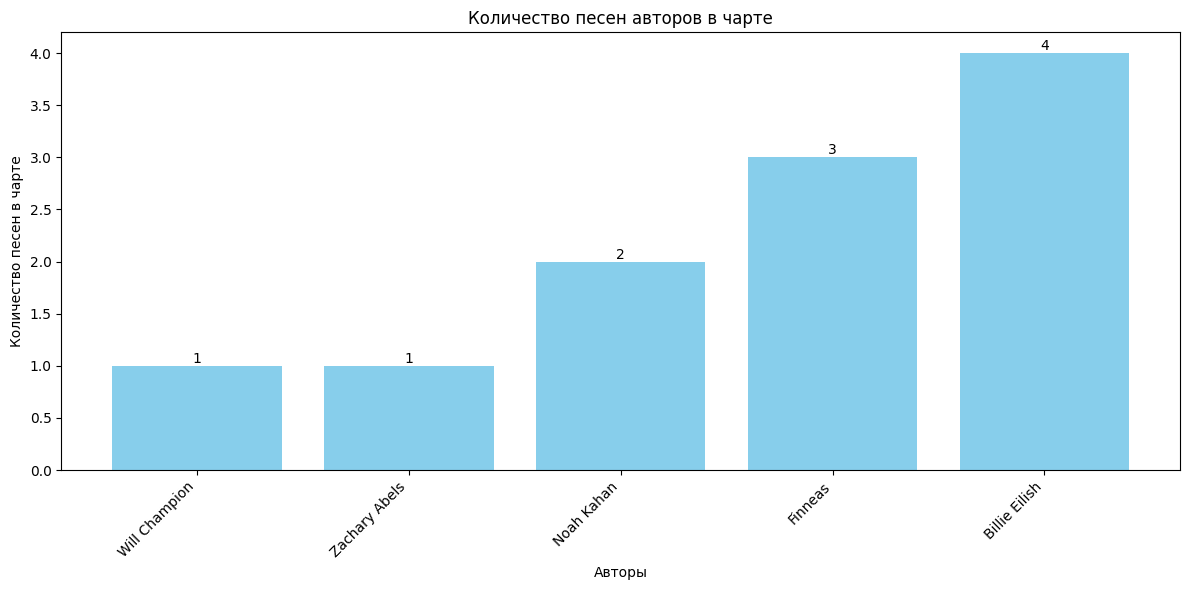

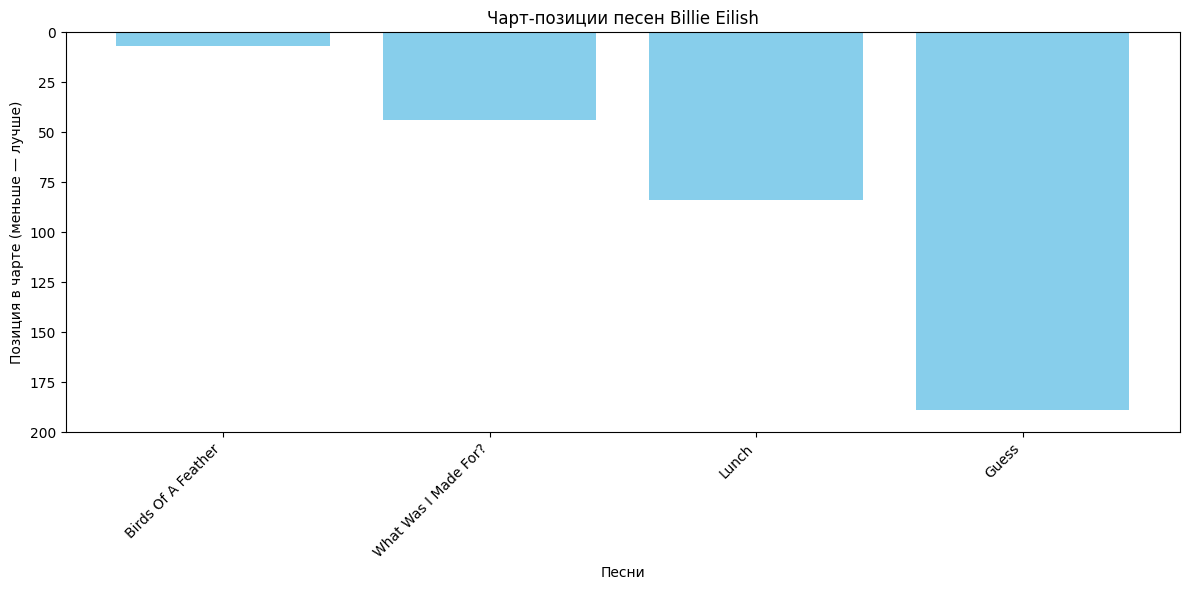

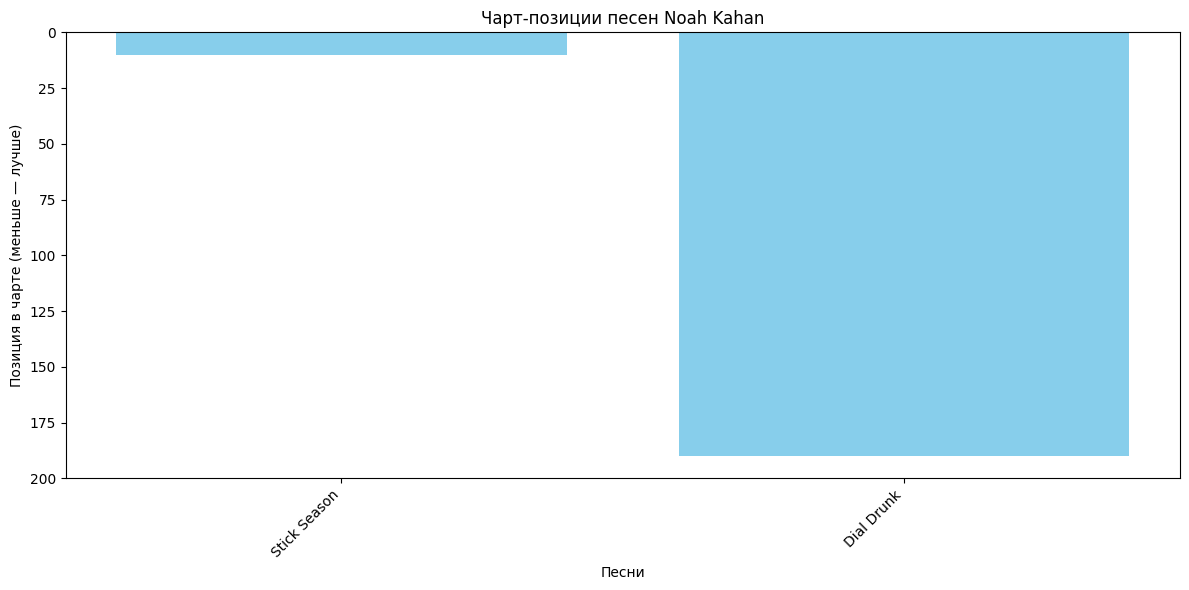

In [31]:
artists_ranked=create_artists_list(chart_alt)
songwriters_chart(create_songwriter_list(df_alt)[-5:])
chart_perfomance_visual(artists_ranked[-1])
chart_perfomance_visual(artists_ranked[-2])

## Выводы 

В ходе анализа удалось узнать, какие артисты и авторы были причастны к наибольшему количеству хитов, попавших в годичный чарт Billboard Global 200 за 2024 год. Среди артистов это были Тейлор Свифт, Билли Айлиш, Викенд, Ариана Гранде, а среди авторов - Викенд, Тейлор Свифт, Билли Айлиш, Макс Мартин, Финнеас, Дуа Липа. Суммируя эти два списка и их визуализации, можно прийти к выводу, что в тройке главных хитмейкеров были Викенд, Тейлор Свифт и Билли Айлиш (и Финнеас, как соавтор её песен). Дальше были рассмотрены 3 самых популярных жанра: в жанре поп однозначно доминирует Тейлор Свифт, а за ней - Дуа Липа и Бруно Марс, в жанре хип-хоп\рэп - Дрейк, Плэйбой Карти и Трэвис Скотт, а в альтернативе главные хитмейкеры Билли Айлиш и её брат Финнеас.
При этом жанр поп, ожидаемо, был самым популярным с большим отрывом. Также можно заметить, что сейчас почти во всех песнях исполнители указаны, как авторы, из-за чего списки популярных авторов и исполнителей были очень похожими.


## Обсуждение

1)В ходе исследования получилось собрать необходимые данные, провести анализ исполнителей и авторов песен, как в целом, так и по жанрам.
2)Не удалось провести анализ продюссеров, а так же вывести какие-то явные закономерности.
3)Если продолжить исследование, то нужно найти новый источник данных, в котором будут указаны продюссеры, а так же увеличить выборку, рассмотреть чарты за несколько лет, чтобы найти более-менее явные закономерности.
4)Это исследование (особенно если рассмотреть большее количество авторов песен) будет полезно дистрибьюторам музыкальных материалов, которые смогут делать предположения об успехе новый или скоро выпущенной песне по исполнителю и авторам (и продюссерам).